
# Implementing DiffPIR

In this tutorial, we revisit the implementation of the DiffPIR diffusion algorithm for image reconstruction from
[Zhou et al.](https://arxiv.org/abs/2305.08995). The full algorithm is implemented in
:class:`deepinv.sampling.diffusion.DiffPIR`.


In [1]:

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2

import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Generate an inverse problem

We first generate a deblurring problem with the Butterly image. We use a square blur kernel of size 5x5 and
Gaussian noise with standard deviation 12.75/255.0.



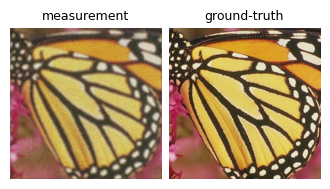

In [2]:
from deepinv.utils.demo import load_url_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = (
    "https://mycore.core-cloud.net/index.php/s/9EzDqcJxQUJKYul/"
    "download?path=%2Fdatasets&files=butterfly.png"
)
x_true = load_url_image(url=url, img_size=256, device=device)
x = x_true.clone()

sigma_noise = 12.75 / 255.0  # noise level

physics = dinv.physics.BlurFFT(
    img_size=(3, x.shape[-2], x.shape[-1]),
    filter=torch.ones((1, 1, 5, 5), device=device) / 25,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=sigma_noise),
)

y = physics(x)

imgs = [y, x_true]
plot(
    imgs,
    titles=["measurement", "ground-truth"],
)


In [3]:
x.shape

torch.Size([1, 3, 256, 256])

## The DiffPIR algorithm

Now that the inverse problem is defined, we can apply the DiffPIR algorithm to solve it. The DiffPIR algorithm is
a diffusion algorithm that alternates between a denoising step, a proximal step and a reverse diffusion sampling step.
The algorithm writes as follows, for $t$ decreasing from $T$ to $1$:

\begin{align}\begin{equation*}
        \begin{aligned}
        x_{0}^{t} &= \left(x_t + (1 - \overline{\alpha}_t)\mathbf{s}_\theta(x_t,t))\right)/\sqrt{\overline{\alpha}_t} \\
        \widehat{x}_{0}^{t} &= \operatorname{prox}_{2 f(y, \cdot) /{\rho_t}}(x_{0}^{t}) \\
        \widehat{\varepsilon} &= \left(x_t - \sqrt{\overline{\alpha}_t} \,\, \widehat{x}_{0}^t\right)/\sqrt{1-\overline{\alpha}_t} \\
        \varepsilon_t &= \mathcal{N}(0, \mathbf{I}) \\
        x_{t-1} &= \sqrt{\overline{\alpha}_t} \,\, \widehat{x}_{0}^t + \sqrt{1-\overline{\alpha}_t} \left(\sqrt{1-\zeta} \,\, \widehat{\varepsilon} + \sqrt{\zeta} \,\, \varepsilon_t\right),
        \end{aligned}
        \end{equation*}\end{align}

where $\mathbf{s}_\theta$ is a denoising network, $\mathcal{N}(0, \mathbf{I})$ is a Gaussian noise
with zero mean and unit variance, and $\zeta$ is a parameter that controls the amount of noise added at each
iteration. The parameters $(\overline{\alpha}_t)_{0\leq t\leq T}$ and $(\rho_t)_{0\leq t\leq T}$ are
sequences of positive numbers, which we will detail later on.

Let us now implement each step of this algorithm.



## Denoising step

In this section, we show how to use the denoising diffusion model from DiffPIR.
The denoising step is implemented by a denoising network conditioned on the noise power. The authors
of DiffPIR use a U-Net architecture, which can be loaded as follows:



In [4]:

model_type = 'imagenet' # 'ffhq'

if model_type == 'imagenet':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/256x256_diffusion_uncond.pt"
    large_model = True
elif model_type == 'ffhq':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/diffusion_ffhq_10m.pt"
    large_model = False

model = dinv.models.DiffUNet(
    pretrained=model_path, large_model=large_model
).to(device)


Now, recall that the forward diffusion can be rewritten as, for all $t$,

\begin{align}\begin{equation*}
        x_t = \sqrt{\overline{\alpha}_t} \widehat{x}_{0} + \sqrt{1-\overline{\alpha}_t} \varepsilon_t.
        \end{equation*}\end{align}

In this context, the denoising diffusion model $s_theta(x, t)$ is trained to approximate $\varepsilon_t$
from $x_t$ and $t$. The denoised image thus writes:

\begin{align}\begin{equation*}
        \widehat{x}_{0} \approx \frac{1}{\sqrt{\overline{\alpha}_t}}x_t-(\frac{1}{\sqrt{\overline{\alpha}_t}}-1) \mathbf{s}_\theta(x_t, t)
        \end{equation*}\end{align}

Before being able to use the pretrained model, we need to define the sequence
$(\overline{\alpha}_t)_{0\leq t\leq T}$. In practice, we will not use $\overline{\alpha}_t$ directly,
but rather other sequences directly deriving from it (e.g. $(1/\sqrt{\overline{\alpha}_t})_{0\leq t\leq T}$).
The following function returns these sequences:




In [5]:
T = 1000  # Number of timesteps used during training


def get_alphas(beta_start=0.1 / 1000, beta_end=20 / 1000, num_train_timesteps=T):
    betas = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float32)
    betas = torch.from_numpy(betas).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas.cpu(), axis=0)  # This is \overline{\alpha}_t
    return torch.tensor(alphas_cumprod)


alphas = get_alphas()



/tmp/ipykernel_627222/1229480470.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(alphas_cumprod)


Now that we have the sequence of interest, there remains to link noise power to the timestep. The following function
returns the timestep corresponding to a given noise power.



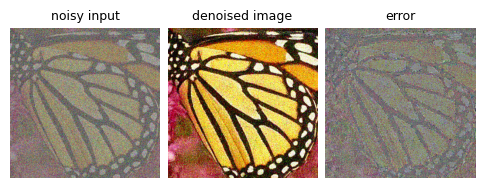

In [6]:
sigmas = torch.sqrt(1.0 - alphas) / alphas.sqrt()


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


t = 100  # choose arbitrary timestep

# We can now apply the model to a noisy image. We first generate a noisy image
x_noisy = x_true + torch.randn_like(x_true) * sigmas[t]

den = model(x_noisy, sigmas[t])

imgs = [x_noisy, den, den - x_true]
plot(
    imgs,
    titles=["noisy input", "denoised image", "error"],
)


## Data fidelity step

The data fidelity step is easily implemented in deepinv. We simply need to define a data fidelity function and use
its prox attribute. For instance:



In [7]:
from deepinv.optim.data_fidelity import IndicatorL2



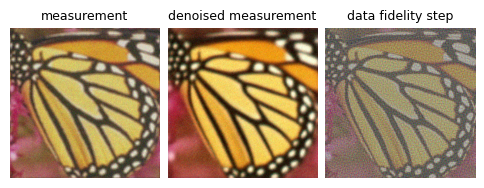

In [8]:
# data_fidelity = L2()

data_fidelity = IndicatorL2(radius=sigma_noise)

# In order to take a meaningful data fidelity step, it is best if we apply it to denoised measurements.
# First, denoise the measurements:
y_denoised = model(y, sigmas[t])

# Next, apply the proximity operator of the data fidelity term (this is the data fidelity step). In the algorithm,
# the regularization parameter is carefully chosen. Here, for simplicity, we set it to :math:`1/\sigma`.
x_prox = data_fidelity.prox(y_denoised, y, physics, gamma=1 / sigmas[t])

imgs = [y, y_denoised, x_prox]
plot(
    imgs,
    titles=["measurement", "denoised measurement", "data fidelity step"],
)



## Sampling step

The last step to be implemented is the DiffPIR sampling step and this can be computed in two steps.
Firstly, we need to compute the effective noise in the estimated reconstruction, i.e. the residual between the previous
reconstruction and the data fidelity step. This is done as follows:



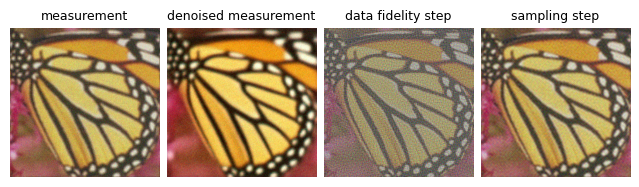

In [9]:
# The diffPIR algorithm assumes that the images are in the range [-1, 1], whereas standard denoisers
# usually output images in the range [0, 1]. This is why we rescale the images before applying the steps.

x_prox_scaled = 2 * x_prox - 1  # Rescale the output of the proximal step in [-1, 1]
y_scaled = 2 * y - 1  # Rescale the measurement in [-1, 1]

t_i = find_nearest(
    sigmas.cpu().numpy(), sigma_noise * 2
)  # time step associated with the noise level sigma
eps = (y_scaled - alphas[t_i].sqrt() * x_prox_scaled) / torch.sqrt(
    1.0 - alphas[t_i]
)  # effective noise

# (notice the rescaling)
#
# Secondly, we need to perform the sampling step, which is a linear combination between the estimated noise and
# the realizations of a Gaussian white noise. This is done as follows:
zeta = 0.3
x_sampled_scaled = alphas[t_i - 1].sqrt() * x_prox_scaled + torch.sqrt(
    1.0 - alphas[t_i - 1]
) * (np.sqrt(1 - zeta) * eps + np.sqrt(zeta) * torch.randn_like(x))

x_sampled = (x_sampled_scaled + 1) / 2  # Rescale the output in [0, 1]

imgs = [y, y_denoised, x_prox, x_sampled]
plot(
    imgs,
    titles=[
        "measurement",
        "denoised measurement",
        "data fidelity step",
        "sampling step",
    ],
)


## Putting it all together: the DiffPIR algorithm

We can now put all the steps together and implement the DiffPIR algorithm. The only remaining step is to set the
noise schedule (i.e. the sequence of noise powers and regularization parameters) appropriately. This is done with the
following function:



<div class="alert alert-info"><h4>Note</h4><p>We only use 30 steps to reduce the computational time of this example. As suggested by the authors of DiffPIR, the
  algorithm works best with ``max_iter = 100``.</p></div>




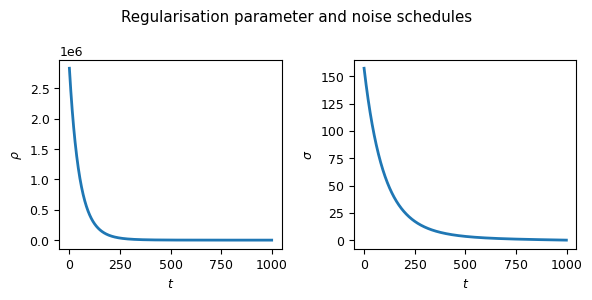

In [10]:
diffusion_steps = 100  # Maximum number of iterations of the DiffPIR algorithm

lambda_ = 7.0  # Regularization parameter

rhos = lambda_ * (sigma_noise**2) / (sigmas**2)

# get timestep sequence
seq = np.sqrt(np.linspace(0, T**2, diffusion_steps))
seq = [int(s) for s in list(seq)]
seq[-1] = seq[-1] - 1


# Plot the noise and regularization schedules
plt.figure(figsize=(6, 3))
plt.rcParams.update({"font.size": 9})
plt.subplot(121)
plt.plot(
    2 / rhos.cpu().numpy()[::-1]
)  # Note that the regularization parameter is 2/rho and not rho
plt.xlabel(r"$t$")
plt.ylabel(r"$\rho$")
plt.subplot(122)
plt.plot(sigmas.cpu().numpy()[::-1])
plt.xlabel(r"$t$")
plt.ylabel(r"$\sigma$")
plt.suptitle("Regularisation parameter and noise schedules")
plt.tight_layout()
plt.show()

Eventually, the DiffPIR algorithm is implemented as follows:




100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


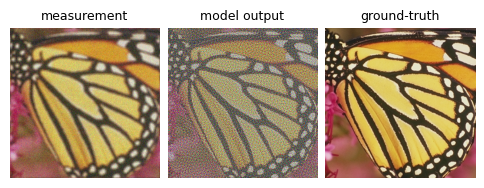

In [11]:
# Initialization
x = 2 * y - 1

with torch.no_grad():
    for i in tqdm(range(len(seq))):
        # Current and next noise levels
        curr_sigma = sigmas[T - 1 - seq[i]].cpu().numpy()

        # 1. Denoising step
        x0 = model(x, curr_sigma)

        if not seq[i] == seq[-1]:
            # 2. Data fidelity step
            t_i = find_nearest(sigmas.cpu(), curr_sigma)

            x0 = data_fidelity.prox(x0, y, physics, gamma=1 / (2 * rhos[t_i]))

            # Normalize data for sampling
            x0 = 2 * x0 - 1
            x = 2 * x - 1

            # 3. Sampling step
            next_sigma = sigmas[T - 1 - seq[i + 1]].cpu().numpy()
            t_im1 = find_nearest(
                sigmas, next_sigma
            )  # time step associated with the next noise level

            eps = (x - alphas[t_i].sqrt() * x0) / torch.sqrt(
                1.0 - alphas[t_i]
            )  # effective noise

            x = alphas[t_im1].sqrt() * x0 + torch.sqrt(1.0 - alphas[t_im1]) * (
                np.sqrt(1 - zeta) * eps + np.sqrt(zeta) * torch.randn_like(x)
            )

            # Rescale the output in [0, 1]
            x = (x + 1) / 2


# Plotting the results
imgs = [y, x, x_true]
plot(
    imgs,
    titles=["measurement", "model output", "ground-truth"],
)



## Directly using the DiffPIR model


In [12]:
from deepinv.sampling.diffusion import DiffPIR



In [36]:


class DummyDataFidelity(torch.nn.Module):
    def __init__(self):
        self.a = 1

    def prox(self, x, y, physics, gamma):
        return x


In [68]:

y = physics(x_true)

diffpir = dinv.sampling.DiffPIR(
    model,
    sigma=sigma_noise,
    max_iter=diffusion_steps,
    lambda_=lambda_,
    zeta=0.5,
    # data_fidelity=dinv.optim.L2(),
    # data_fidelity=IndicatorL2(radius=(1e7*np.sqrt(2*sigma_noise**2)).astype(np.float32)),
    data_fidelity=DummyDataFidelity(),
    verbose=True,
    device=device
)


In [69]:

x_init = 2 * physics.A_adjoint(y) - 1


In [82]:

xhat = diffpir.forward(y, physics)


In [83]:

# l2 = dinv.optim.L2(sigma=sigma_noise)
# likelihood = l2.d(x_true, x)
# likelihood


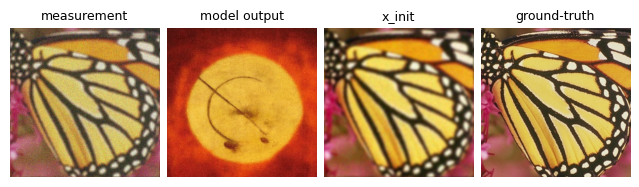

In [84]:

# Plotting the results
imgs = [y, xhat, x_init, x_true]
plot(
    imgs,
    titles=["measurement", "model output", "x_init", "ground-truth"],
)



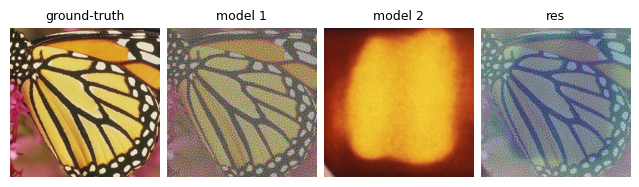

In [44]:

# Plotting the results
imgs = [x_true, x, xhat, x - xhat]
plot(
    imgs,
    titles=["ground-truth", "model 1", "model 2", "res"],
)


